### This notebook investigates the role that dead-end metabolite Nitrous Oxide plays in the E. coli metabolism
A small purpose is to activate RXN0-2721, which is the reaction that produces nitrous oxide in cytosol.
- [ ] remove oxygen exchange + add reaction that breaks nitrous oxide into nitrogen and oxygen
- [ ] find info on dinitrification of nitrous oxide in literature
- [ ] consider kinetic rates for Nitrogen (N) related reactions

In [1]:
import numpy as np
import ast
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx
import plotly.express as px

from scipy.special import logsumexp

%matplotlib inline
%load_ext autoreload
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")


In [2]:
# load basal new model
time = '400'
date = '2025-03-19'
experiment = 'NEW_force_flow'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
bulk = pd.DataFrame(output['bulk'])
bulk = bulk.loc[24, :]
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

metabolism = agent['ecoli-metabolism-redux-classic']
fba_new_reaction_ids = metabolism.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism.parameters['fba_reaction_ids_to_base_reaction_ids']
binary_kinetic_idx = metabolism.binary_kinetic_idx[0].copy()
metabolites = metabolism.metabolite_names

homeostatic_count = pd.DataFrame(fba["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).loc[24, :]
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]

In [3]:
fba['target_kinetic_bounds'][-1][-3:]

[[0, 3860], [0, 56286], [47272, 47272]]

In [377]:
uptake = metabolism.allowed_exchange_uptake.copy()
uptake = set(uptake)

addition = set([
    # "NITROUS-OXIDE[e]",
    "NITRATE[e]",
    # "Donor-H1[e]",
    # "OXYGEN-MOLECULE[e]",
    # "NITRITE[e]",
    # "NITRIC-OXIDE[e]",
    
])
removals = set([
    "OXYGEN-MOLECULE[p]",
])


uptake = uptake | addition
uptake = uptake - removals

new_exchange_molecule = ['NITROGEN-MOLECULE[p]', 'NITROUS-OXIDE[p]', 'NITRIC-OXIDE[e]', 'NITRITE[e]'] #'Donor-H1[e]','Donor-H1[p]'
exchange_molecules = metabolism.exchange_molecules.copy()
exchange_molecules = exchange_molecules | set(new_exchange_molecule)

In [378]:
# exchange_molecules
metabolites.index('Donor-H1[p]')
exchange_molecules

{'ACET[p]',
 'AMMONIUM[c]',
 'BETAINE[p]',
 'BUTANAL[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CARBON-MONOXIDE[p]',
 'CH33ADO[c]',
 'CL-[p]',
 'CO+2[p]',
 'CPD-10774[p]',
 'CPD-108[p]',
 'CPD-1772[c]',
 'CPD-239[p]',
 'CPD-534[p]',
 'CPD-560[p]',
 'CPD-564[c]',
 'CPD0-2167[c]',
 'D-ALANINE[p]',
 'D-LACTATE[p]',
 'ETOH[p]',
 'FE+2[p]',
 'FE+3[p]',
 'FORMATE[p]',
 'GLC[p]',
 'GLYCEROL[p]',
 'GLYCOLALDEHYDE[c]',
 'GLYCOLLATE[c]',
 'HYDROGEN-MOLECULE[c]',
 'HYPOXANTHINE[p]',
 'INDOLE[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'METOH[p]',
 'MG+2[p]',
 'MI-PENTAKISPHOSPHATE[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'NITRIC-OXIDE[e]',
 'NITRITE[e]',
 'NITROGEN-MOLECULE[p]',
 'NITROUS-OXIDE[p]',
 'OXYGEN-MOLECULE[p]',
 'PROTON[p]',
 'Pi[p]',
 'S-ADENOSYL-4-METHYLTHIO-2-OXOBUTANOATE[c]',
 'SUC[p]',
 'SULFATE[p]',
 'THYMINE[p]',
 'UNDECAPRENYL-DIPHOSPHATE[p]',
 'URACIL[p]',
 'UREA[p]',
 'WATER[p]',
 'XANTHINE[p]',
 'ZN+2[p]'}

In [441]:
# TODO: Add transport of N2 and reduction of NITROUS-OXIDE[p] to NITROGEN-MOLECULE[p] and OXYGEN-MOLECULE[p]
stoichiometry = metabolism.stoichiometry
reaction_names = metabolism.reaction_names.copy()
kinetic_reaction_ids = metabolism.kinetic_constraint_reactions.copy()
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]

print(stoichiometry.shape)

ADD_METABOLITE = True
ADD_REACTION = True
ADD_KINETIC = True
FORCE_REACTION = True

add_metabolite = ['NITROGEN-MOLECULE[c]', 'NITROGEN-MOLECULE[p]', 'NITROGEN-MOLECULE[e]', 'Donor-H1[e]']
add_reaction = {
    'TEMP-Denitrification': {
        'NITROUS-OXIDE[c]': -2,
        'NITROGEN-MOLECULE[c]': 2,
        'OXYGEN-MOLECULE[c]': 1
    },
    'TEMP-TRANSPORT-NITROGEN[c]->[p]': {
        'NITROGEN-MOLECULE[c]': -1,
        'NITROGEN-MOLECULE[p]': 1
    },
    'TEMP-TRANSPORT-NITROGEN[p]->[e]': {
        'NITROGEN-MOLECULE[p]': -1,
        'NITROGEN-MOLECULE[e]': 1
    },
    'TEMP-TRANSPORT-NITROUS_OXIDE[c]->[p]': {
        'NITROUS-OXIDE[c]': -1,
        'NITROUS-OXIDE[p]': 1
    },
    'TEMP-TRANSPORT-NITROUS_OXIDE[c]->[p](reverse)': {
        'NITROUS-OXIDE[c]': 1,
        'NITROUS-OXIDE[p]': -1
    },
    'TEMP-TRANSPORT-NITRIC_OXIDE[c]->[p]': {
        'NITRIC-OXIDE[c]': -1,
        'NITRIC-OXIDE[p]': 1
    },
    'TEMP-TRANSPORT-NITRIC_OXIDE[c]->[p](reverse)': {
        'NITRIC-OXIDE[c]': 1,
        'NITRIC-OXIDE[p]': -1
    },
    # 'TEMP-TRANSPORT-Donor[c]->[p]':{
    #     'Donor-H1[c]': -1,
    #     'Donor-H1[p]': 1
    # },
    # 'TEMP-TRANSPORT-Donor[c]->[p](reverse)': {
    #     'Donor-H1[c]': 1,
    #     'Donor-H1[p]': -1
    # },
    # 'TEMP-TRANSPORT-Donor[e]->[p]': {
    #     'Donor-H1[e]': -1,
    #     'Donor-H1[p]': 1
    # },
    # 'TEMP-TRANSPORT-Donor[e]->[p](reverse)': {
    #     'Donor-H1[e]': 1,
    #     'Donor-H1[p]': -1
    # },
    'TEMP-NITRITE-REDUCTION':{
        'NITRITE[c]': -1,
        'NITRIC-OXIDE[c]': 1
    },

}
add_kinetic = {
    'TEMP-Denitrification': 500,
    'TRANS-RXN0-239': 350000,
    # 'RXN-23850 (reverse)': 100,
}

# force_reaction = ['RXN0-6369-NITRATE/CPD-9956//NITRITE/UBIQUINONE-8/WATER.45.',
#                   'NITRATE-REDUCTASE-CYTOCHROME-RXN-Reduced-NapC-proteins/NITRATE/PROTON//Oxidized-NapC-proteins/NITRITE/WATER.75.',
#                   # 'TRANS-RXN-137',
#                   # 'RXN-23850 (reverse)'
#                   ] #'RXN-23850 (reverse)'
# force_reaction = ['TEMP-TRANSPORT-Donor[c]->[p](reverse)', 'RXN-22651']
# force_reaction = ['RXN0-2721','TEMP-Denitrification']
force_reaction = ['R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.']
# force_reaction = ['RXN-23850 (reverse)']

remove_reaction = None
# remove_reaction = ['R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.', 
#                    'R621-RXN-NITRIC-OXIDE/NADPH/OXYGEN-MOLECULE//NITRATE/NADP/PROTON.56.']

# add NITROGEN-MOLECULE to metabolites list because they are currently not included in the model
S_new = stoichiometry.copy()
if ADD_METABOLITE:
    for m in add_metabolite:
        if m not in metabolites:
            metabolites.append(m)
    # append rows of zeros to S_new of length add_metabolite
    S_new = np.concatenate((S_new, np.zeros((len(add_metabolite), S_new.shape[1]))), axis=0)
    print(S_new.shape)

# add new reaction names:
# 1. TEMP-Denitrification: NITROUS-OXIDE[c] -> NITROGEN-MOLECULE[c] + OXYGEN-MOLECULE[c]
# 2. TEMP-TRANSPORT-NITROGEN[c]->[p]: NITROGEN-MOLECULE[c] -> NITROGEN-MOLECULE[p]
# 3. TEMP-TRANSPORT-NITROGEN[p]->[e]: NITROGEN-MOLECULE[p] -> NITROGEN-MOLECULE[e]

if ADD_REACTION:
    for r,s in add_reaction.items():
        if r not in reaction_names:
            reaction_names.append(r)
        # append columns of reaction stoich to S_new of length add_reaction
        new_reaction = np.zeros((S_new.shape[0], 1))
        for m, v in s.items():
            new_reaction[metabolites.index(m), 0] = v
        S_new = np.concatenate((S_new, new_reaction), axis=1)
    print(S_new.shape)
    
# if among the new reactions added, we want to set kinetic constraints
# modify kinetic_reactions and kinetic_targets
if ADD_KINETIC:
    for r, v in add_kinetic.items():
        if r not in kinetic_reaction_ids:
            kinetic_reaction_ids.append(r)
            kinetic[r] = v

if remove_reaction is not None:
    for r in remove_reaction:
        r_idx = reaction_names.index(r)
        S_new = np.delete(S_new, r_idx, axis=1)
        reaction_names.remove(r)
        if r in kinetic_reaction_ids:
            kinetic_reaction_ids.remove(r)
            del kinetic[r]
            
if FORCE_REACTION:
    force_reaction_idx = np.array([reaction_names.index(r) for r in force_reaction])
else:
    force_reaction_idx = None

force_reaction_idx

(6076, 9358)
(6080, 9358)
(6080, 9366)


array([1667])

In [442]:
FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.001}
model = NetworkFlowModel(
            stoich_arr=S_new,
            metabolites=metabolism.metabolite_names,
            reactions=reaction_names,
            homeostatic_metabolites=metabolism.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
model.set_up_exchanges(exchanges=exchange_molecules, uptakes=uptake)
solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count * metabolism.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())), # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            # binary_kinetic_idx=binary_kinetic_idx, #7646
            binary_kinetic_idx=binary_kinetic_idx,
            force_flow_idx=force_reaction_idx,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP) #SCS. ECOS
print(f'Optimal objective function reached is: {solution.objective}')

Optimal objective function reached is: 31914.5244932055


In [443]:
solution_denitrification = solution.velocities
sim_flux_denitrification = pd.DataFrame({
    'flux': solution_denitrification,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in reaction_names
    ]
}, index=reaction_names)

In [444]:
reaction_names.index("TRANS-RXN0-239")
reaction_names.index("RXN0-2721")
# reaction_names.index('TEMP-TRANSPORT-Donor[c]->[p]')
# reaction_names.index("R621-RXN-NITRIC-OXIDE/NADH/OXYGEN-MOLECULE//NITRATE/NAD/PROTON.54.")
# np.append(binary_kinetic_idx, [2846])

3186

In [445]:
sim_flux_denitrification.loc['RXN-22651 (reverse)', 'flux']

-0.0

In [446]:
reaction_names[2804]

'RXN-22650'

In [447]:
np.append(binary_kinetic_idx, 7464)

array([ 136,  137,  273,  274,  435,  436,  437,  551,  554,  656,  729,
       1029, 1035, 1176, 1294, 1309, 1369, 1370, 1676, 1677, 1717, 1767,
       2065, 2493, 2494, 2495, 2496, 2576, 2579, 2580, 2838, 2922, 2923,
       3213, 3221, 3222, 3398, 3399, 3400, 3401, 3402, 3403, 3467, 3489,
       3610, 3617, 3734, 6799, 6913, 6916, 6931, 6932, 6941, 7212, 7288,
       7289, 7290, 7291, 7292, 7293, 7294, 7401, 7402, 7403, 7404, 7405,
       7406, 7407, 7408, 7409, 7410, 7451, 7452, 7453, 7454, 7455, 7456,
       7457, 7458, 7459, 7460, 7461, 7462, 7634, 7635, 7636, 8011, 8012,
       8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023,
       8057, 9301, 9327, 7464])

In [448]:
# temp = pd.DataFrame(solution.velocities, index=reaction_names)
# plt.plot(temp, solution_denitrification, 'o')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

In [449]:
def get_subset_S(S, met_of_interest):
    S_met = S.loc[met_of_interest, :]
    S_met = S_met.loc[:,~np.all(S_met == 0, axis=0)]
    return S_met, S_met.columns

In [450]:
met_of_interest = ['NITROUS-OXIDE[c]','NITROUS-OXIDE[p]','NITROUS-OXIDE[e]', 'NITRIC-OXIDE[c]', 'NITRIC-OXIDE[p]',
                   'NITRITE[c]', 'NITRITE[p]','NITRATE[c]', 'NITRATE[p]', 'NITRATE[e]',
                   'NITROGEN-MOLECULE[c]', 'NITROGEN-MOLECULE[p]']
S_new = pd.DataFrame(S_new, index=metabolites, columns=reaction_names)
S_met, rxn_denitrification = get_subset_S(S_new, met_of_interest)
S_met

,1.7.2.2-RXN-A-REDUCED-TORY-PROTEIN/NITRITE/PROTON//AMMONIUM/an-oxidized-TorY-protein/WATER.79.,1.7.2.2-RXN-Cytochromes-C-Reduced/NITRITE/PROTON//AMMONIUM/Cytochromes-C-Oxidized/WATER.76.,1.7.2.2-RXN-Cytochromes-C550-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C550-Ox/WATER.72.,1.7.2.2-RXN-Cytochromes-C552-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C552-Ox/WATER.72.,1.7.2.2-RXN-Cytochromes-C554-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C554-Ox/WATER.72.,1.7.2.2-RXN-Cytochromes-CL-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-CL-Ox/WATER.68.,1.7.2.2-RXN-Reduced-NapC-proteins/NITRITE/PROTON//AMMONIUM/Oxidized-NapC-proteins/WATER.76.,1.7.2.2-RXN-Reduced-cytochromes-c2/NITRITE/PROTON//AMMONIUM/Oxidized-cytochromes-c2/WATER.78.,1.7.2.2-RXN-Reduced-cytochromes-c553/NITRITE/PROTON//AMMONIUM/Oxidized-cytochromes-c553/WATER.82.,1.7.2.2-RXN-a-reduced-NrfB-protein/NITRITE/PROTON//AMMONIUM/an-oxidized-NrfB-protein/WATER.79.,...,TRANS-RXN0-601-NITRITE//NITRITE.17.,TRANS-RXN0-601-NITRITE//NITRITE.17. (reverse),TEMP-Denitrification,TEMP-TRANSPORT-NITROGEN[c]->[p],TEMP-TRANSPORT-NITROGEN[p]->[e],TEMP-TRANSPORT-NITROUS_OXIDE[c]->[p],TEMP-TRANSPORT-NITROUS_OXIDE[c]->[p](reverse),TEMP-TRANSPORT-NITRIC_OXIDE[c]->[p],TEMP-TRANSPORT-NITRIC_OXIDE[c]->[p](reverse),TEMP-NITRITE-REDUCTION
NITROUS-OXIDE[c],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
NITROUS-OXIDE[p],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
NITROUS-OXIDE[e],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NITRIC-OXIDE[c],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0
NITRIC-OXIDE[p],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
NITRITE[c],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
NITRITE[p],-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NITRATE[c],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NITRATE[p],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NITRATE[e],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [451]:
rxn_denitrification_flux = sim_flux_denitrification.loc[rxn_denitrification]
rxn_denitrification_flux['kinetic'] = [kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_denitrification_flux.index]
rxn_denitrification_flux

,flux,is_new,kinetic
1.7.2.2-RXN-A-REDUCED-TORY-PROTEIN/NITRITE/PROTON//AMMONIUM/an-oxidized-TorY-protein/WATER.79.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Cytochromes-C-Reduced/NITRITE/PROTON//AMMONIUM/Cytochromes-C-Oxidized/WATER.76.,358799.005495,Old Reactions,False
1.7.2.2-RXN-Cytochromes-C550-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C550-Ox/WATER.72.,0.000000,Old Reactions,False
1.7.2.2-RXN-Cytochromes-C552-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C552-Ox/WATER.72.,0.000000,Old Reactions,False
1.7.2.2-RXN-Cytochromes-C554-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C554-Ox/WATER.72.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Cytochromes-CL-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-CL-Ox/WATER.68.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Reduced-NapC-proteins/NITRITE/PROTON//AMMONIUM/Oxidized-NapC-proteins/WATER.76.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Reduced-cytochromes-c2/NITRITE/PROTON//AMMONIUM/Oxidized-cytochromes-c2/WATER.78.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Reduced-cytochromes-c553/NITRITE/PROTON//AMMONIUM/Oxidized-cytochromes-c553/WATER.82.,0.000000,Old Reactions,False
1.7.2.2-RXN-a-reduced-NrfB-protein/NITRITE/PROTON//AMMONIUM/an-oxidized-NrfB-protein/WATER.79.,0.000000,Old Reactions,False


In [ ]:
sim_flux_denitrification.loc['TEMP-Denitrification']

In [375]:
S_new.loc[:,'RXN-22001 (reverse)'][S_new.loc[:,'RXN-22001 (reverse)'] != 0]

NADH[c]                        -1.0
NAD[c]                          1.0
Oxidized-Flavorubredoxins[c]   -2.0
PROTON[c]                       1.0
Reduced-Flavorubredoxins[c]     2.0
Name: RXN-22001 (reverse), dtype: float64

In [55]:
for rxn in reaction_names:
    if 'TRANS-RXN-137' in rxn:
        print(rxn)

TRANS-RXN-137
TRANS-RXN-137 (reverse)


In [449]:
met_of_interest = ['NITRIC-OXIDE[c]', 'NITRIC-OXIDE[p]', 'NITRIC-OXIDE[e]', 'NITRITE[c]','NITRITE[p]','NITRITE[e]']
S_met, rxn_NO = get_subset_S(S_new, met_of_interest)
S_met.T

,NITRIC-OXIDE[c],NITRIC-OXIDE[p],NITRIC-OXIDE[e],NITRITE[c],NITRITE[p],NITRITE[e]
1.7.2.2-RXN-A-REDUCED-TORY-PROTEIN/NITRITE/PROTON//AMMONIUM/an-oxidized-TorY-protein/WATER.79.,0.0,0.0,0.0,0.0,-1.0,0.0
1.7.2.2-RXN-Cytochromes-C-Reduced/NITRITE/PROTON//AMMONIUM/Cytochromes-C-Oxidized/WATER.76.,0.0,0.0,0.0,0.0,-1.0,0.0
1.7.2.2-RXN-Cytochromes-C550-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C550-Ox/WATER.72.,0.0,0.0,0.0,0.0,-1.0,0.0
1.7.2.2-RXN-Cytochromes-C552-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C552-Ox/WATER.72.,0.0,0.0,0.0,0.0,-1.0,0.0
1.7.2.2-RXN-Cytochromes-C554-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C554-Ox/WATER.72.,0.0,0.0,0.0,0.0,-1.0,0.0
1.7.2.2-RXN-Cytochromes-CL-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-CL-Ox/WATER.68.,0.0,0.0,0.0,0.0,-1.0,0.0
1.7.2.2-RXN-Reduced-NapC-proteins/NITRITE/PROTON//AMMONIUM/Oxidized-NapC-proteins/WATER.76.,0.0,0.0,0.0,0.0,-1.0,0.0
1.7.2.2-RXN-Reduced-cytochromes-c2/NITRITE/PROTON//AMMONIUM/Oxidized-cytochromes-c2/WATER.78.,0.0,0.0,0.0,0.0,-1.0,0.0
1.7.2.2-RXN-Reduced-cytochromes-c553/NITRITE/PROTON//AMMONIUM/Oxidized-cytochromes-c553/WATER.82.,0.0,0.0,0.0,0.0,-1.0,0.0
1.7.2.2-RXN-a-reduced-NrfB-protein/NITRITE/PROTON//AMMONIUM/an-oxidized-NrfB-protein/WATER.79.,0.0,0.0,0.0,0.0,-1.0,0.0


In [450]:
rxn_denitrification_flux

,flux,is_new,kinetic
1.7.2.2-RXN-A-REDUCED-TORY-PROTEIN/NITRITE/PROTON//AMMONIUM/an-oxidized-TorY-protein/WATER.79.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Cytochromes-C-Reduced/NITRITE/PROTON//AMMONIUM/Cytochromes-C-Oxidized/WATER.76.,384734.000000,Old Reactions,False
1.7.2.2-RXN-Cytochromes-C550-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C550-Ox/WATER.72.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Cytochromes-C552-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C552-Ox/WATER.72.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Cytochromes-C554-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C554-Ox/WATER.72.,0.000000,Old Reactions,False
1.7.2.2-RXN-Cytochromes-CL-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-CL-Ox/WATER.68.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Reduced-NapC-proteins/NITRITE/PROTON//AMMONIUM/Oxidized-NapC-proteins/WATER.76.,-0.000000,Old Reactions,False
1.7.2.2-RXN-Reduced-cytochromes-c2/NITRITE/PROTON//AMMONIUM/Oxidized-cytochromes-c2/WATER.78.,0.000000,Old Reactions,False
1.7.2.2-RXN-Reduced-cytochromes-c553/NITRITE/PROTON//AMMONIUM/Oxidized-cytochromes-c553/WATER.82.,-0.000000,Old Reactions,False
1.7.2.2-RXN-a-reduced-NrfB-protein/NITRITE/PROTON//AMMONIUM/an-oxidized-NrfB-protein/WATER.79.,0.000000,Old Reactions,False


In [21]:
sum(rxn_denitrification_flux.loc[['TRANS-RXN-137','RXN0-2721'], 'flux'])

1.4999390089067486e-06

In [235]:
solution.velocities[reaction_names.index('RXN0-2721')]

732790.1999999954

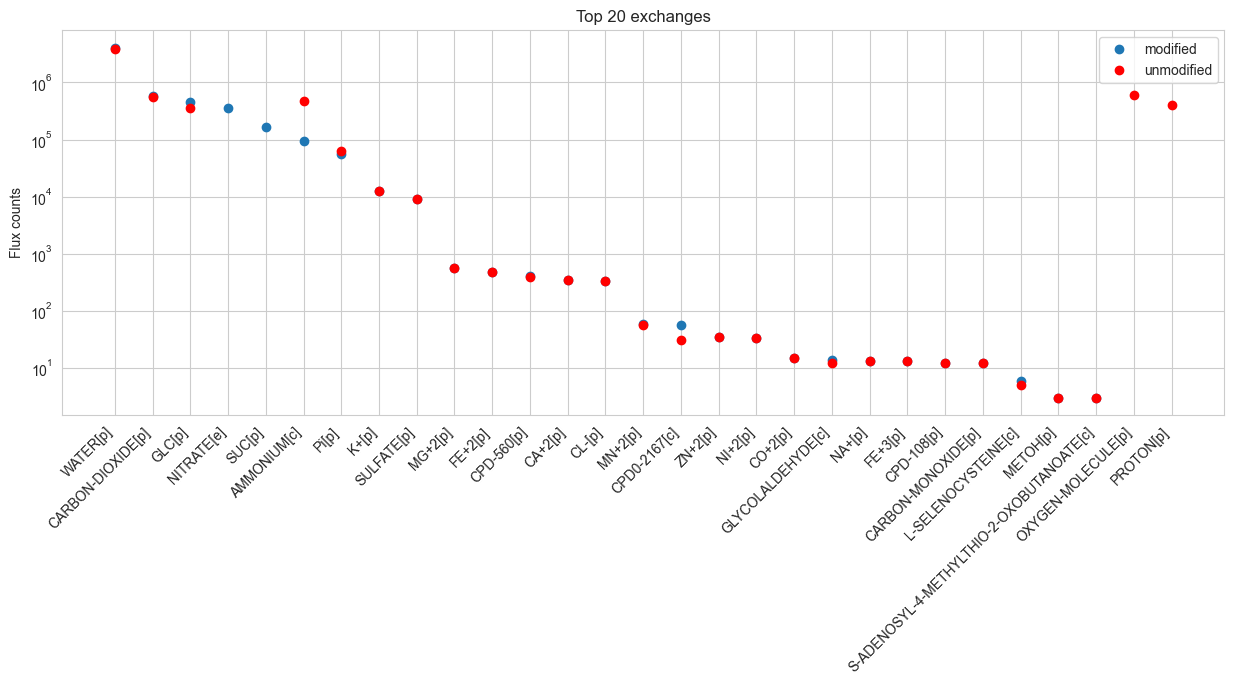

In [226]:
%matplotlib inline
# plot exchanges for basal unchanged model and new model
cur_exchanges = pd.Series(solution.exchanges, index=metabolism.metabolite_names).abs().sort_values(ascending=False)
sim_exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[24, :].abs().sort_values(ascending=False)
cur_nonzero = len(cur_exchanges[cur_exchanges > 0])
sim_nonzero = len(sim_exchanges[sim_exchanges > 0])

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_exchanges.head(cur_nonzero).index, cur_exchanges.head(cur_nonzero), 'o', label = 'modified')
plt.plot(sim_exchanges.head(sim_nonzero).index, sim_exchanges.head(sim_nonzero), 'ro', label = 'unmodified')

# shorten all xtick names to 10 characters
# plt.xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
plt.xticks(rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 20 exchanges')
plt.legend()
plt.show()

In [389]:
catalyst_of_interest = ['G7866-MONOMER[c]','CPLX0-1[c]','EG12450-MONOMER[c]', '']
def get_counts(bulk, catalysts, bulk_ids):
    bulk_idx = bulk_name_to_idx(catalysts, bulk_ids)
    out = counts(bulk, bulk_idx)
    # out.index = catalysts
    return out

get_counts(bulk, catalyst_of_interest, metabolism.bulk_ids)
# bulk_name_to_idx(catalyst_of_interest, metabolism.bulk_ids)

9652    21
5217     3
7800     8
Name: 24, dtype: int64

In [181]:
for met in metabolism.metabolite_names:
    if 'Donor-H1' in met:
        print(met)

Donor-H1[c]
Donor-H1[i]
Donor-H1[p]


In [182]:
for bulk_id in metabolism.bulk_ids:
    if 'Donor-H1' in bulk_id:
        print(bulk_id)

In [143]:
metabolism.bulk_ids[9652]

'PHES-CPLX[c]'

In [183]:
metabolism.homeostatic_metabolites

array(['2-3-DIHYDROXYBENZOATE[c]', '2-KETOGLUTARATE[c]', '2-PG[c]',
       '2K-4CH3-PENTANOATE[c]', '4-AMINO-BUTYRATE[c]',
       '4-hydroxybenzoate[c]', 'ACETOACETYL-COA[c]', 'ACETYL-COA[c]',
       'ACETYL-P[c]', 'ADENINE[c]', 'ADENOSINE[c]', 'ADP-D-GLUCOSE[c]',
       'ADP[c]', 'AMP[c]', 'ANTHRANILATE[c]', 'APS[c]', 'ARG[c]',
       'ASN[c]', 'ATP[c]', 'BIOTIN[c]', 'CA+2[c]', 'CAMP[c]',
       'CARBAMYUL-L-ASPARTATE[c]', 'CARBON-DIOXIDE[c]', 'CDP[c]',
       'CHORISMATE[c]', 'CIS-ACONITATE[c]', 'CIT[c]', 'CL-[c]', 'CMP[c]',
       'CO+2[c]', 'CO-A[c]', 'CPD-12115[c]', 'CPD-12261[p]',
       'CPD-12575[c]', 'CPD-12819[c]', 'CPD-12824[c]', 'CPD-13469[c]',
       'CPD-2961[c]', 'CPD-8260[c]', 'CPD-9956[c]', 'CPD0-939[c]',
       'CTP[c]', 'CYS[c]', 'CYTIDINE[c]', 'CYTOSINE[c]', 'D-ALA-D-ALA[c]',
       'D-SEDOHEPTULOSE-7-P[c]', 'DAMP[c]', 'DATP[c]', 'DCTP[c]',
       'DEOXY-RIBOSE-5P[c]', 'DEOXYADENOSINE[c]', 'DEOXYGUANOSINE[c]',
       'DGMP[c]', 'DGTP[c]', 'DI-H-OROTATE[c]',
       '

In [188]:
solution.dm_dt[metabolism.metabolite_names.index('Donor-H1[c]')]

0.0

In [230]:
cur_exchanges.loc['Donor-H1[c]']

0.0